In [5]:
#primero importamos todos los paquetes necesarios
import torch #contiene todas las funciones de PyTorch
import torch.nn as nn #contiene la clase padre de todos los modelos (nn.Module)
import torch.nn.functional as F #esencial para la función de activación 
import torchvision #fundamental para la importación de imágenes
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt #para poder representar las gráficas
import numpy as np #para las métricas de la red

In [6]:
#importamos los paquetes necesarios para el cálculo de las métricas
import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns

In [7]:
#en este script se entrenarán modelos que siguen una estructura idéntica a la relatada en los siguientes artículos:
# - Automatic Detection and Classification of Diabetic Retinopathy stages using CNN (Ghosh R.,Ghosh K.)
# - Classification of Diabetic Retinopathy Images Based on Customised CNN Architecture (Mobeen-ur-Rehman)
# - Diagnosis of retinal disorders from Optical Coherence Tomography images using CNN (Rajagopalan N., Venkateswaran N.)
# - AOCT-NET: a convolutional network automated classification of multiclass retinal diseases using spectral-domain optical coherence tomography images (Alqudah A.)

In [8]:
#establecemos el tamaño del batch, la escala de las imágenes y el número de épocas de entrenamiento
#debido a que cada una de las arquitecturas requiere una escala de imagen específica, la escala y los loaders serán definidas para cada arquitectura
batch = 4
#comenzaremos con la arquitectura propuesta por Ghosh, con una escala de 512, 512, 3
escala = 512
epocas = 50

In [9]:
#a continuación definimos la operación que permitirá transformar las imágenes del repositorio en Tensores que puedan ser empleados por PyTorch
transform = transforms.Compose(
    [transforms.ToTensor(), #transforma la imagen de formato PIL a formato tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normaliza el tensor para que la media de sus valores sea 0 y su desviación estándar 0.5
     transforms.Resize((escala, escala))]) #redimensionamos las imágenes

In [10]:
#a continuación cargamos el conjunto de imágenes de train (OCT) y los dos de test (iPhone y Samsung)
OCT = ImageFolder(root = 'Datos/Classified Data/Images/OCT', transform = transform)
print(f'Tamaño del conjunto de datos de train: {len(OCT)}')

Samsung = ImageFolder(root = 'Datos/Classified Data/Images/Samsung', transform = transform)
print(f'Tamaño del conjunto de datos de test de Samsung: {len(Samsung)}')

iPhone = ImageFolder(root = 'Datos/Classified Data/Images/iPhone', transform = transform)
print(f'Tamaño del conjunto de datos de test de iPhone: {len(iPhone)}')

Tamaño del conjunto de datos de train: 113
Tamaño del conjunto de datos de test de Samsung: 93
Tamaño del conjunto de datos de test de iPhone: 99


In [11]:
#establecemos una lista con el nombre de las etiquetas
classes = OCT.classes

In [12]:
#y definimos también las funciones que van a ir cargando las imágenes en el modelo
train_loader = DataLoader(
    dataset = OCT,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 4, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_S_loader = DataLoader(
    dataset = Samsung,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_i_loader = DataLoader(
    dataset = iPhone,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

In [13]:
#en esta ocasión, para mayor sencillez del código, vamos a omitir el paso de representación de las imágenes (además sabemos que los DataLoaders funcionan correctamente pues son los mismos que los empleados en el script 'Primera_Red_Básica')

In [43]:
#ARQUITECTURA DEFINIDA POR GHOSH
class Ghosh(nn.Module):
    #esta estructura está formada por capas convolucionales, de maxpooling, de activación, de Dropout, fully-connected y de clasificación
    
    def __init__(self):
        #sobreescribimos el constructor del padre
        super(Ghosh,self).__init__()
        #primero definimos una capa convolucional
        self.conv1 = nn.Conv2d(
            in_channels = 3, #3 canales de entrada porque las imágenes son a color
            out_channels = 32, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 7, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la segunda (y tercera) capa convolucional, se pueden definir como una única porque el número de entradas y salidas coincide
        self.conv2_3 = nn.Conv2d(
            in_channels = 32, #32 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 32, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la cuarta capa convolucional
        self.conv4 = nn.Conv2d(
            in_channels = 32, #32 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 64, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la quinta capa convolucional
        self.conv5 = nn.Conv2d(
            in_channels = 64, #64 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 64, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la sexta capa convolucional
        self.conv6 = nn.Conv2d(
            in_channels = 64, #64 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 128, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la séptima (y octava y novena) capa convolucional
        self.conv7_8_9 = nn.Conv2d(
            in_channels = 128, #64 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 128, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la décima capa convolucional
        self.conv10 = nn.Conv2d(
            in_channels = 128, #64 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 256, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #las últimas 3 capa convolucionales
        self.conv11_12_13 = nn.Conv2d(
            in_channels = 256, #64 canales de entrada para que coincida con las salidas de la capa anterior
            out_channels = 256, #se trata del número de salidas de la capa. Es el número de kernels de la capa
            kernel_size = 3, #suele tratarse de un número impar
            stride = 2, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 2, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #la función de activación (en este caso PReLU)
        self.activation = nn.PReLU()
        
        #la capa de MaxPool
        self.pool = nn.MaxPool2d(
            kernel_size = 2, #establecemos el tamaño del kernel a 2*2
            stride = 2 #cantidad píxeles que se desplaza el filtro sobre la imagen
        )
        
        #la primera capa de neuronas a la que aplicaremos Dropout como técnica de regularización
        self.fc1 = nn.Linear(
            in_features = 256, #número de características de entrada
            out_features = 256 #número de neuronas de salida
        )
        
        #la segunda capa fully-connected
        self.fc2 = nn.Linear(256,1024)
        
        #la tercera capa fully-connected
        self.fc3 = nn.Linear(1024,512)
        
        #la capa de neuronas fully-connected final
        self.dense = nn.Linear(
            in_features = 512, #número de parámetros de entrada de la red (los valores se obtienen experimentalmente)
            out_features = 5 #número de neuronas de salida
        )
        
    def forward(self,x):
        #en esta función es donde tiene lugar la computación (y la función invocada por defecto al ejecutar la red)
        #siguiendo la estructura descrita en Ghosh et al.:
        
        #primero una capa convolucional de tipo 1, con su consecuente activación PReLU y la capa de MaxPool
        x = self.pool(self.activation(self.conv1(x)))
        #una capa convolucional de tipo 2 con su correspondiente activación
        x = self.activation(self.conv2_3(x))
        #capa convolucional de tipo 2 con activación y MaxPool
        x = self.pool(self.activation(self.conv2_3(x)))
        #cuarta convolucional con activación
        x = self.activation(self.conv4(x))
        #quinta convolucional con activación y MaxPool
        x = self.pool(self.activation(self.conv5(x)))
        #3 capas convolucionales consecutivas de tipo 2 con su correspondiente activación
        x = self.activation(self.conv6(x))
        x = self.activation(self.conv7_8_9(x))
        x = self.activation(self.conv7_8_9(x))
        #novena capa convolucional con activación y MaxPool
        x = self.pool(self.activation(self.conv7_8_9(x)))
        #se repite la misma estructura de 3 capas convolucionales con activación y una última con activación y MaxPool
        x = self.activation(self.conv10(x))
        x = self.activation(self.conv11_12_13(x))
        x = self.activation(self.conv11_12_13(x))
        x = self.pool(self.activation(self.conv11_12_13(x)))
        #aplanamos la salida, hasta convertirla de forma matricial a forma vectorial (sería la capa flatten)
        x = x.view(-1,self.num_flat_features(x))#usamos una función propia de la clase para obtener el número de características
        #aplicamos una primera red neuronal fully-connected, con la activación consecuente y la estrategia dropout para evitar el sobreentrenamiento
        x = F.dropout(self.activation(self.fc1(x)))
        #lo mismo sucede con la segunda capa fully-connected
        x = F.dropout(self.activation(self.fc2(x)))
        #y con la tercera
        x = F.dropout(self.activation(self.fc3(x)))
        #por último tiene lugar la capa de predicciones, que convierte las 512 neuronas de la tercera capa fully-connected en una salida de 5 neuronas (una por clase)
        x = self.dense(x)
        
        return x
    
    def num_flat_features(self,x):
        #por último definimos la función que permite obtener el número de características de los tensores
        size = x.size()[1:] #seleccionamos todas las dimensiones expcepto la primera (que son los batches)
        num_features = 1
        #va iterando y calcula el número de características de los datos (x)
        for s in size:
            num_features*=s
        return num_features

In [44]:
#creamos una instancia de esta red
ghosh = Ghosh()
#mostramos su estructura
print(ghosh)

Ghosh(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
  (conv2_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv7_8_9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv11_12_13): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (activation): PReLU(num_parameters=1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (dense): Linear(in_features=512, out_featu

In [45]:
#definimos como loss la función de tipo cross entropy 
criterion = nn.CrossEntropyLoss() 

In [46]:
#en este caso el optimizador será la función Adam (ampliamente utilizada)
optimizer = torch.optim.Adam(params = ghosh.parameters(), lr = 0.01) #incrementamos el valor del learning rate a 0.01

In [47]:
#definimos 2 listas en las que almacenaremos los valores de accuracy y loss de cada época para poder graficarlo posteriormente
acc_graph = []
loss_graph = []
#para entrenar el modelo vamos a iterar el número de épocas determinadas, calculando el valor de loss y accuracy para cada época
for epoch in range(epocas):
    #establecemos el número de predicciones correctas inicial a 0
    correct = 0
    total = 0
    #y cargamos las imágenes de entrenamiento y sus etiquetas usando la estructura Loader previamente creada
    for i, data in enumerate(train_loader):
        inputs, labels = data
        #establecemos a 0 los parámetros del modelo
        optimizer.zero_grad()
        #generamos las predicciones de los inputs
        outputs = ghosh(inputs)
        #calculamos el loss, la desviación de las predicciones con respecto a las etiquetas
        loss = criterion(outputs, labels)
        #propagamos hacia atrás el valor loss
        loss.backward()
        #y modificamos los pesos en función del loss y la función optimizer
        optimizer.step()
        #actualizamos el número de predicciones correctas
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    #una vez finalizada la época (que recorre todo el conjunto de imágenes) mostramos el valor del loss y del accuracy
    print(f'Época {epoch +1}/{epocas} - Accuracy: {correct/len(OCT)} - Loss: {loss.data.item()}')
    #añadimos los valores a la lista correspondiente
    loss_graph.append(loss.data.item())
    acc_graph.append(correct/len(OCT))

Época 1/50 - Accuracy: 0.3008849557522124 - Loss: 0.6626059412956238
Época 2/50 - Accuracy: 0.4336283185840708 - Loss: 1.5326260328292847
Época 3/50 - Accuracy: 0.49557522123893805 - Loss: 0.8032357692718506
Época 4/50 - Accuracy: 0.49557522123893805 - Loss: 1.5383954048156738
Época 5/50 - Accuracy: 0.45132743362831856 - Loss: 1.6979864835739136
Época 6/50 - Accuracy: 0.4247787610619469 - Loss: 46.12579345703125


KeyboardInterrupt: 

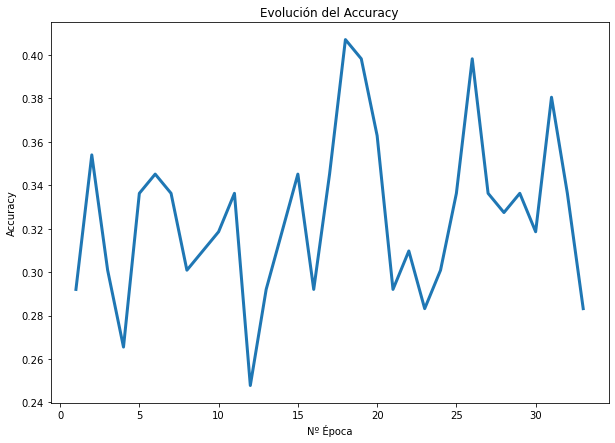

In [72]:
#a continuación mostramos la evolución temporal del accuracy
plt.figure(figsize = (10,7))
plt.title('Evolución del Accuracy')
plt.xlabel('Nº Época')
plt.ylabel('Accuracy')
plt.plot(range(1,epocas+1),acc_graph, linewidth = 3)
plt.show()

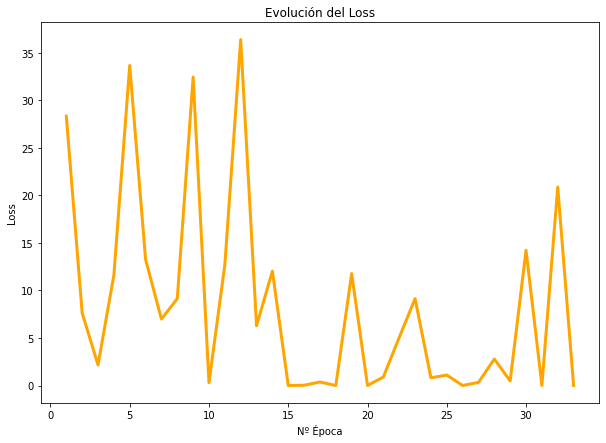

In [73]:
#a continuación mostramos la evolución temporal del loss
plt.figure(figsize = (10,7))
plt.title('Evolución del Loss')
plt.xlabel('Nº Época')
plt.ylabel('Loss')
plt.plot(range(1,epocas+1),loss_graph, color='orange', linewidth = 3)
plt.show()

In [49]:
#por último solo debemos generar las predicciones a partir de la red entrenada
#creamos 2 listas para almacenar las etiquetas reales y las etiquetas predichas y así poder calcular las métricas
y_true_iphone = []
y_pred_iphone = []
#creamos una para almacenar también la salida del modelo, para posteriormente poder calcular AUC
predictions = []
#y definimos una función para convertir esa salida a forma de probabilidad (usando Softmax como en la arquitectura de Ghosh)
m = nn.Softmax(dim=1)
#es importante activar torch.no_grad() para que la red no entrene al pasarle el conjunto de test, no varíen los pesos
with torch.no_grad():
    #recorremos el conjunto de imágenes de test de iPhone
    for data in test_i_loader:
        images, labels = data #cargamos las imágenes y las etiquetas del dataloader
        outputs = ghosh(images) #obtenemos las predicciones
        predictions.append(m(outputs).numpy()) #las convertimos a probabilidad mediante Softmax 
        _, predicted = torch.max(outputs.data,1) #y obtenemos las etiquetas o labels predichas a partir de la probabilidad
        y_pred_iphone.append(predicted.numpy()) #añadimos la predicción a la lista de predicciones
        y_true_iphone.append(labels.numpy()) #y añadimos la etiqueta real a la lista de etiquetas reales
#convertimos los datos a formato np.array de una única dimensión        
y_true_iphone = np.concatenate(y_true_iphone)
y_pred_iphone = np.concatenate(y_pred_iphone)
predictions = np.concatenate(predictions)

AxesSubplot(0.125,0.125;0.775x0.755)
El valor de accuracy del modelo con imágenes de iphone es: 0.29292929292929293
El valor de balanced accuracy del modelo con imágenes de iphone es: 0.23053613053613056
El valor de F-score del modelo con imágenes de iphone es: 0.22687068544735134
El valor de Kappa del modelo con imágenes de iphone es: 0.05003427004797811
El valor de AUC del modelo con imágenes de iphone es: 0.5211514157400863


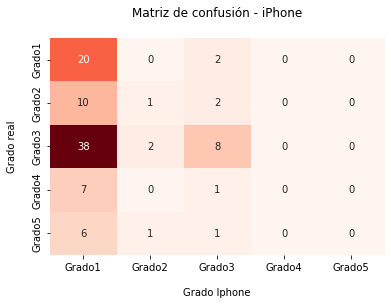

In [50]:
#a partir de las predicciones y las labels reales podemos calcular las métricas deseadas
#primero la matriz de confusión
matrix_iphone = confusion_matrix(y_true_iphone, y_pred_iphone)
#usamos el paquete seaborn para mostrar de manera más visual la matriz de confusión
plot = sns.heatmap(matrix_iphone, annot = True, cmap = 'Reds', cbar = False)
#establecemos título
plot.set_title('Matriz de confusión - iPhone\n')
#título de cada eje
plot.set_xlabel('\nGrado Iphone')
plot.set_ylabel('Grado real\n')
#y el significado de cada fila y columna de la matriz
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

#calculamos el valor de accuracy
accuracy_iphone = accuracy_score(y_true = y_true_iphone, y_pred = y_pred_iphone)
print(f'El valor de accuracy del modelo con imágenes de iphone es: {accuracy_iphone}')
#el balanced accuracy
bal_acc_iphone = balanced_accuracy_score(y_true = y_true_iphone, y_pred = y_pred_iphone)
print(f'El valor de balanced accuracy del modelo con imágenes de iphone es: {bal_acc_iphone}')
#el F-score
f_score_iphone = f1_score(y_true = y_true_iphone, y_pred = y_pred_iphone,average = 'weighted')
print(f'El valor de F-score del modelo con imágenes de iphone es: {f_score_iphone}')
#calculamos el valor de quadratic weighted kappa
kappa_iphone = cohen_kappa_score(y1 = y_true_iphone, y2 = y_pred_iphone)
print(f'El valor de Kappa del modelo con imágenes de iphone es: {kappa_iphone}')
#y por último calculamos el valor de AUC bajo la curva ROC
auc_iphone = roc_auc_score(y_true = y_true_iphone, y_score = predictions, multi_class = 'ovr')
print(f'El valor de AUC del modelo con imágenes de iphone es: {auc_iphone}')

In [51]:
#realizamos el mismo proceso para las imágenes de Samsung
#creamos 2 listas para almacenar las etiquetas reales y las etiquetas predichas y así poder calcular las métricas
y_true_samsung = []
y_pred_samsung = []
#creamos una para almacenar también la salida del modelo, para posteriormente poder calcular AUC
predictions = []
#y definimos una función para convertir esa salida a forma de probabilidad (usando Softmax)
m = nn.Softmax(dim=1)
#es importante activar torch.no_grad() para que la red no entrene al pasarle el conjunto de test, no varíen los pesos
with torch.no_grad():
    #recorremos el conjunto de imágenes de test de Samsung en este caso 
    for data in test_S_loader:
        images, labels = data #cargamos las imágenes y las etiquetas del dataloader
        outputs = ghosh(images) #obtenemos las predicciones
        predictions.append(m(outputs).numpy()) #las convertimos a probabilidad mediante Softmax 
        _, predicted = torch.max(outputs.data,1) #y obtenemos las etiquetas o labels predichas a partir de la probabilidad
        y_pred_samsung.append(predicted.numpy()) #añadimos la predicción a la lista de predicciones
        y_true_samsung.append(labels.numpy()) #y añadimos la etiqueta real a la lista de etiquetas reales
#convertimos los datos a formato np.array de una única dimensión 
y_true_samsung = np.concatenate(y_true_samsung)
y_pred_samsung = np.concatenate(y_pred_samsung)
predictions = np.concatenate(predictions)

AxesSubplot(0.125,0.125;0.775x0.755)
El valor de accuracy del modelo con imágenes de samsung es: 0.25806451612903225
El valor de balanced accuracy del modelo con imágenes de samsung es: 0.17327659574468085
El valor de F-score del modelo con imágenes de samsung es: 0.18637992831541222
El valor de Kappa del modelo con imágenes de samsung es: -0.04460361386944478
El valor de AUC del modelo con imágenes de samsung es: 0.5275870390413006


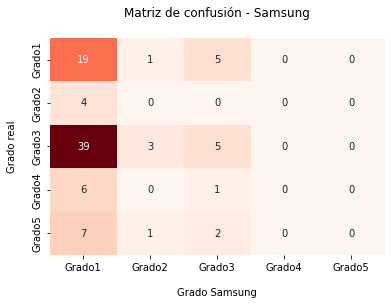

In [52]:
#a partir de las predicciones y las labels reales podemos calcular las métricas deseadas
matrix_samsung = confusion_matrix(y_true_samsung, y_pred_samsung)
plot = sns.heatmap(matrix_samsung, annot = True, cmap = 'Reds', cbar = False)
#establecemos título
plot.set_title('Matriz de confusión - Samsung\n')
#título de cada eje
plot.set_xlabel('\nGrado Samsung')
plot.set_ylabel('Grado real\n')
#y el significado de cada fila y columna de la matriz
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

#calculamos el valor de accuracy
accuracy_samsung = accuracy_score(y_true = y_true_samsung, y_pred = y_pred_samsung)
print(f'El valor de accuracy del modelo con imágenes de samsung es: {accuracy_samsung}')
#el balanced accuracy
bal_acc_samsung = balanced_accuracy_score(y_true = y_true_samsung, y_pred = y_pred_samsung)
print(f'El valor de balanced accuracy del modelo con imágenes de samsung es: {bal_acc_samsung}')
#el F-score
f_score_samsung = f1_score(y_true = y_true_samsung, y_pred = y_pred_samsung,average = 'weighted')
print(f'El valor de F-score del modelo con imágenes de samsung es: {f_score_samsung}')
#calculamos el valor de quadratic weighted kappa
kappa_samsung = cohen_kappa_score(y1 = y_true_samsung, y2 = y_pred_samsung)
print(f'El valor de Kappa del modelo con imágenes de samsung es: {kappa_samsung}')
#y por último calculamos el valor de AUC bajo la curva ROC
auc_samsung = roc_auc_score(y_true = y_true_samsung, y_score = predictions, multi_class = 'ovr')
print(f'El valor de AUC del modelo con imágenes de samsung es: {auc_samsung}')

In [3]:
#una vez finalizado la construcción del modelo basado en Ghosh repetimos el proceso pero en este caso siguiendo la arquitectura planteada por Mobeen-ur-Rehman

In [4]:
#debido a que en esta arquitectura no se especifica un tamaño de escala en particular, el valor se mantendrá sin modificar
#procedo directamente a definir la arquitectura

In [ ]:
#ARQUITECTURA DEFINIDA POR MOBEEN-UR-REHMAN
class Mobeen(nn.Module):
    
    def __init__(self):
        super(Mobeen,self).__init__()
        